***
### <font color=red>Chapter 5: TALN PII Case Study - Bypass Manual Labeling Process</font>
<p style="margin-left:10%; margin-right:10%;">by <font color=teal> John Doe (typica.ai) </font></p>

***


#### Overview:
This notebook creates the OCI Data Labeling `Pii Fr Dataset V2.0.0` from the pre-prepared CSV file `pii_fr_dataset_v2.0.0.csv` (containing all the needed labels, including credit card labels).

# 1. Data Access:
- **Purpose:** Retrieve the V2 dataset.
- **Method:** load the CSV file `pii_fr_dataset_v2.0.0.csv` directly into a new huggingface dataset `pii_fr_dataset_v2`.

In [9]:
import warnings
warnings.filterwarnings('ignore')

from datasets import load_dataset
pii_fr_dataset_v2 = load_dataset("csv", data_files="./data/pii_fr_dataset_v2.0.0.csv")
pii_fr_dataset_v2

pii_fr_dataset_v2["train"][0]

{'unmasked_text': 'Salut Sophie, vos données de santé récemment téléchargées sur https://extroverted-priesthood.com sont protégées. Seuls les membres Director peuvent y accéder pour les analyser.',
 'span_labels': "[[6, 12, 'FIRSTNAME_1']]"}

# 2. Dataset V2 Creation:
- **Purpose:** Transform the Hugging Face dataset to a DLS dataset (Jsonl Consolidated files).
- **Method:** create the DLS Dataset `Pii Fr Dataset V2.0.0` Jsonl Consolidated files and stores them in the Labeling Datasets Bucket under the folder `pii_fr_dataset_v2.0.0`.

In [22]:
## Cheking the V2 Dataset label's distribution

Define helper functions to plot the label's distribution of the V2 Dataset

In [19]:
from collections import Counter
import ast
import matplotlib.pyplot as plt

def extract_labels(span_labels):
    """Helper function to parse and filter labels from span_labels."""
    return [label[2] for label in ast.literal_eval(span_labels) if label[2] != 'O']

def count_labels(dataset):
    """Counts occurrences of each label in the dataset's span_labels field, excluding 'O'."""
    # Use a list comprehension to gather all labels across the dataset and count them
    label_counts = Counter(
        label for example in dataset['train']
        for label in extract_labels(example['span_labels'])
    )
    return label_counts

def plot_distributions(counts, process="V2 Dataset"):
    # Sort labels to ensure they match up in the plot
    labels = sorted(counts.keys())
    values = [counts[label] for label in labels]
    x = range(len(labels))  # Label location on x-axis
    # Create the bar plot
    plt.figure(figsize=(10, 5))
    plt.bar(x, values, width=0.4, label=f'{process}', color='b', align='center')
    # Add some text for labels, title and custom x-axis tick labels, etc.
    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.title(f'Label Distribution for {process}')
    plt.xticks(x, labels, rotation='vertical')
    plt.legend()
    # Show the plot
    plt.tight_layout()
    plt.show()

Calculates and plot the label's distribution of the V2 Dataset

Label Counts: Counter({'FIRSTNAME_1': 2111, 'CREDITCARDNUMBER_1': 1867, 'LASTNAME_1': 1336, 'EMAIL_1': 1235, 'AGE_1': 1125, 'STREET_1': 1109, 'ZIPCODE_1': 1067, 'CREDITCARDISSUER_1': 993, 'MIDDLENAME_1': 989, 'CITY_1': 921, 'PHONENUMBER_1': 880, 'CREDITCARDCVV_1': 562})


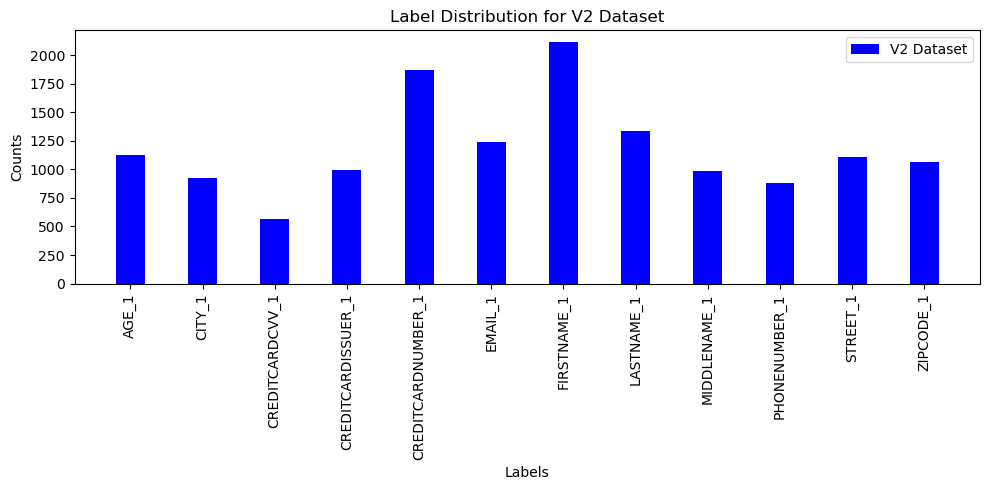

In [23]:
# count labels for the cleaned dataset
pii_fr_dataset_v2_label_counts = count_labels(pii_fr_dataset_v2)
print("Label Counts:", pii_fr_dataset_v2_label_counts)
plot_distributions(pii_fr_dataset_v2_label_counts,'V2 Dataset')  # Plot the label counts

Our V2 dataset is balanced enough. We can notice the presence, in our V2 dataset, of the credit card-related labels e.g., `CREDITCARDNUMBER_1`). 

Before we now proceed with the creation of the v2 DLS dataset, let's save the dataset `pii_fr_dataset_v2.0.0` to the `training_datasets_bkt` as a restore point (if needed).

In [24]:
pii_fr_dataset_v2.save_to_disk('/home/datascience/buckets/training_datasets_bkt/pii_fr_dataset_v2.0.0')

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Let's create the OCI Data Labeling dataset in Jsonl Consolidated format.

In [25]:
import oci
from datasets import load_dataset
import json
import io
import os
import tempfile
from tqdm import tqdm

# Initialize OCI Object Storage Client with notebook session's resource principal
signer = oci.auth.signers.get_resource_principals_signer()
object_storage_client = oci.object_storage.ObjectStorageClient(config={}, signer=signer)

# Initialize Object Storage bucket infos
namespace = object_storage_client.get_namespace().data
bucket_name = "labelling_datasets_bkt"

# Base folder in the bucket
base_folder = "pii_fr_dataset_v2.0.0/"

# Function to strip "_1" from labels
def strip_label(label):
    return label.rsplit("_", 1)[0] if "_" in label else label

labels_set = set()
annotations_list = []

for idx, item in enumerate(tqdm(pii_fr_dataset_v2["train"], 
                                desc="processing V2 dataset records", 
                                total=len(pii_fr_dataset_v2["train"])
                               )
                          ):
    text = item['unmasked_text']
    span_labels = eval(item['span_labels'])  # Convert string to list if necessary

    # Prepare annotations for this row
    entities = []
    for start, end, label in span_labels:
        label = strip_label(label)
        labels_set.add(label)  # Add to the set of unique labels
        entities.append({
            "entityType": "TEXTSELECTION",
            "labels": [{"label_name": label}],
            "textSpan": {"offset": start, "length": end - start}
        })

    if len(entities) > 0:
        file_name = f"rec-{idx}.txt"
        annotations_list.append({
            "sourceDetails": {"path": file_name},
            "annotations": [{"entities": entities}]
        })

        # Upload the text to OCI bucket
        record_filename = f"{base_folder}{file_name}"
        record_body = io.BytesIO(text.encode('utf-8'))
        
        object_storage_client.put_object(namespace,
                                         bucket_name,
                                         record_filename,
                                         record_body,
                                         content_type='text/plain')
        
# Prepare the dataset metadata, i.e., JSONL Metadata
dataset_details = {
    "displayName": "PII Fr Dataset v2.0.0",
    "description": "PII Case Study - Dataset ready for training (contains all the needed labels, including credit card-related labels.",    
    "labelsSet": [{"name": label} for label in labels_set],
    "annotationFormat": "ENTITY_EXTRACTION",
    "datasetFormatDetails": {"formatType": "TEXT"}
}

# Metadata and annotations as JSONL string
jsonl_data = json.dumps(dataset_details) + '\n' + '\n'.join(json.dumps(annotation) for annotation in annotations_list)

# Write the metadata and annotations to a JSONL file
# Use tempfile to create a temporary file for JSONL content
with tempfile.NamedTemporaryFile(delete=False, mode='w', suffix='.jsonl') as tmpfile:
    json.dump(dataset_details, tmpfile)
    tmpfile.write('\n')
    for annotation in annotations_list:
        json.dump(annotation, tmpfile)
        tmpfile.write('\n')
    tmpfile_path = tmpfile.name  # Save the path for uploading

# Upload the JSONL file to OCI bucket
with open(tmpfile_path, 'rb') as f:
    objStoreResp = object_storage_client.put_object(namespace,
                                                    bucket_name,
                                                    f"{base_folder}dataset_metadata.jsonl",
                                                    f,
                                                    content_type='application/json'  # Set the Content-Type for the object
                                                   )

print(f'The Dataset {dataset_details["displayName"]} was created successfully in the bucket {bucket_name}')

# Optionally delete the temporary file
os.remove(tmpfile_path)

processing V2 dataset records: 100%|██████████| 10000/10000 [04:53<00:00, 34.08it/s]


The Dataset PII Fr Dataset v2.0.0 was created successfully in the bucket labelling_datasets_bkt
